## REI602M Machine Learning - Homework 4
### Due: Sunday 10.2.2019

**Objectives**: Support vector machines, feature selection. 

**Name**: Emil Gauti Friðriksson, **email: ** egf3@hi.is, **collaborators:** (if any)

Please provide your solutions by filling in the appropriate cells in this notebook, creating new cells as needed. Hand in your solution on Gradescope, taking care to locate the appropriate page numbers in the PDF document. Make sure that you are familiar with the course rules on collaboration (encouraged) and copying (very, very, bad).

1) [Stochastic gradient descent for SVM, 40 points]. In this problem you are to implement a stochastic gradient descent algorithm for training a linear SVM. The model is $f_\theta(x)=\theta^T x$ (to include an intercept term you can simply set $x_0=1$ as before). The algorithm minimizes the SVM objective function
$$
   J(\theta) = \frac{\lambda}{2}\theta^T \theta + \frac{1}{n} \sum_{i=1}^n \max(0, 1-y^{(i)}\theta^T x^{(i)}).
$$
The hinge loss $\max(0, 1-z)$ is not differentiable at $z=1$ and this results in a objective function which is not differentiable everywhere, hence the gradient of $J(\theta)$ is not defined everywhere. To deal with this, the SGD algorithm uses the *sub-gradient* of $J$ instead (see below). The algorithm starts from $\theta^{(0)}=0$ and performs a fixed number of iterations, with step $k$ as follows:

Select $i$ uniformly at random from $[1,n]$

$\alpha^{(k)} = \frac{1}{\lambda k}$

if $y^{(i)}~(\theta^{(k)})^T x^{(i)} < 1 ~\textrm{then}$

$\quad \theta^{(k+1)} = \theta^{(k)} - \alpha^{(k)}(\lambda \theta^{(k)} - y^{(i)} x^{(i)})$

else

$\quad \theta^{(k+1)} = \theta^{(k)} - \alpha^{(k)} \lambda \theta^{(k)}$

where $\theta^{(k)}$ denotes the parameter *vector* in iteration $k$ and $\lambda>0$ is a regularization hyper-parameter. The step size $\alpha^{(k)}$ decays over the course of iterations instead of being constant as we've seen in previous implementations of SGD.

a) [20 points] Implement the SGD algorithm above and use it to classify dataset `hw3_data_a` from homework 3 using $\lambda=1/100$. Report the model coefficients and training set accuracy.

*Comments*:

1) To sample uniformly at random from $[0,n-1]$ use `np.random.randint`.

2). A *sub-gradient* is a generalization of the gradient for convex functions which are not necessarily differentiable. Such functions arise quite frequently in machine learning, e.g. when one is using the 1-norm for regularization. The sub-gradient of a function at a point is the slope of *a* hyperplane that passes through the point and lies below the graph of the function. We will not cover sub-gradients in more detail in this course.

[-2.8028028   3.04449458  2.4393433 ]


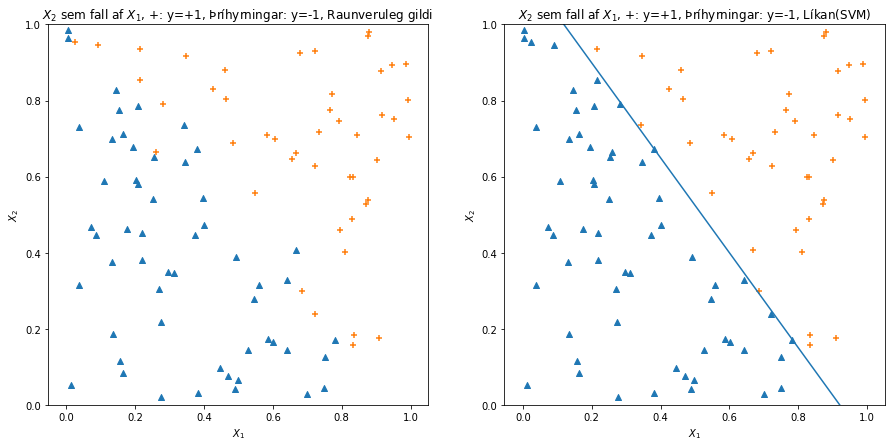

In [2]:
import matplotlib.pyplot as plt
import numpy as np
def svm_sgd(X,y,lambda_par,max_epochs=10):
    # X ... Input variables (n x p matrix)
    # y ... Labels (n vector), -1 or 1
    # lambda_par ... Regularization constant (non-negative)
    # max_epochs ... Maximum number of "passes" through the data set

    assert(lambda_par > 0)
    n = X.shape[0]
    p = X.shape[1]
    max_iter = max_epochs*n
    theta = np.zeros(p)
    for k in range(1,max_iter):
        i = np.random.randint(n)
        alpha = 1/(lambda_par*k)
        if y[i]*theta.T@X[i,:]<1:
            theta = theta - alpha*(lambda_par*theta-y[i]*X[i,:])
        else:
            theta = theta - alpha*lambda_par*theta
    return theta
    
    

y,X1,X2 = np.loadtxt('hw3_data_a.txt',unpack=True)
X = np.c_[np.ones(len(X1)),X1,X2]
theta = svm_sgd(X,y,1/100,10)
print(theta)
#print(X)
X1_m = X1[np.where(y == -1)]
X1_p = X1[np.where(y == 1)]
X2_m = X2[np.where(y == -1)]
X2_p = X2[np.where(y == 1)]
sign = theta@X.T
X_neg = X[np.where(sign<0)]
X_pos = X[np.where(sign>=0)]
z = np.linspace(0,1,100)
f = (-theta[1]*z-theta[0])/theta[2]
plt.figure(figsize = (15,7))
plt.subplot(1,2,1)

plt.scatter(X1_m,X2_m, marker='^')
plt.scatter(X1_p,X2_p, marker='+')
plt.title('$X_2$ sem fall af $X_1$, +: y=+1, Þríhyrningar: y=-1, Raunveruleg gildi')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.ylim(0,1)
plt.subplot(1,2,2)
plt.scatter(X_neg[:,1],X_neg[:,2],marker='^')
plt.scatter(X_pos[:,1],X_pos[:,2],marker='+')
plt.plot(z,f)
plt.ylim(0,1)
plt.title('$X_2$ sem fall af $X_1$, +: y=+1, Þríhyrningar: y=-1, Líkan(SVM)')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.show()

b) [20 points] Train a linear SVM classifier on a subset of the MNIST dataset from homework 3 consisting of digits 5 and 8 only. Keep track of the objective function value and training set error during the course of iterations. 

i) Plot the objective function values and training set error as a function of iteration number. Consider using a log-scale for iteration and/or objective values (see e.g. `matplotlib.pyplot.loglog`).

ii) Evaluate classifier accuracy using the test set (digits 5 and 8 only) using your classifier.

iii) Compare the accuracy of your classifier with the SVM implementation in `sklearn.svm.LinearSVC`.

*Comments*:

1) Computing the function values and training set error requires a pass through all the training data. This is computationally expensive, especially for large data sets, so you should compute these values once every $T$ iterations where $T$ could e.g. be 100, 1000 or $n$.

2) To speed up computations use matrix and vector operations instead of *for*-loops where possible. For example, if the training set is in matrix $X$ you can classify all the examples in a single matrix-vector multiplication, $y_{pred}=X\theta$. This issue is discussed in some detail in http://cs229.stanford.edu/section/vec_demo/Vectorization_Section.pdf

3) You can use the following code to discard all but classes 5 and 8 with `x_train, y_train = filter_classes(x_train, y_train, 5, 8)`

```python
def filter_classes(X, y, cls1, cls2):
    # Reduces training set (X,y) so that it contains only labels cls1, cls2 and then maps the labels to {-1,1}
    cond = np.logical_or(y == cls1, y == cls2) 
    X_red = X[cond,:]
    y_red = [-1 if c==cls1 else 1 for c in y[cond]]
    return X_red, y_red```
    
4) Note that the $\lambda$ parameter in the above SVM formulation is related to the $C$ parameter in the "standard" SVM formulation via $\lambda=1/(nC)$.

In [4]:
def filter_classes(X, y, cls1, cls2):
    # Reduces training set (X,y) so that it contains only labels cls1, cls2 and then maps the labels to {-1,1}
    cond = np.logical_or(y == cls1, y == cls2) 
    X_red = X[cond,:]
    y_red = [-1 if c==cls1 else 1 for c in y[cond]]
    return X_red, y_red

In [5]:
#Load data
data=np.load('mnist.npz')
X_train=data['x_train']
y_train=data['y_train']
X_val=data['x_val']
y_val=data['y_val']
X_test=data['x_test']
y_test=data['y_test']
#Reducing data
X_train, y_train = filter_classes(X_train,y_train,5,8)
X_val,y_val = filter_classes(X_val,y_val,5,8)
X_test,y_test = filter_classes(X_test,y_test,5,8)

Train Error:    0.0416


Text(0.5,0,'k')

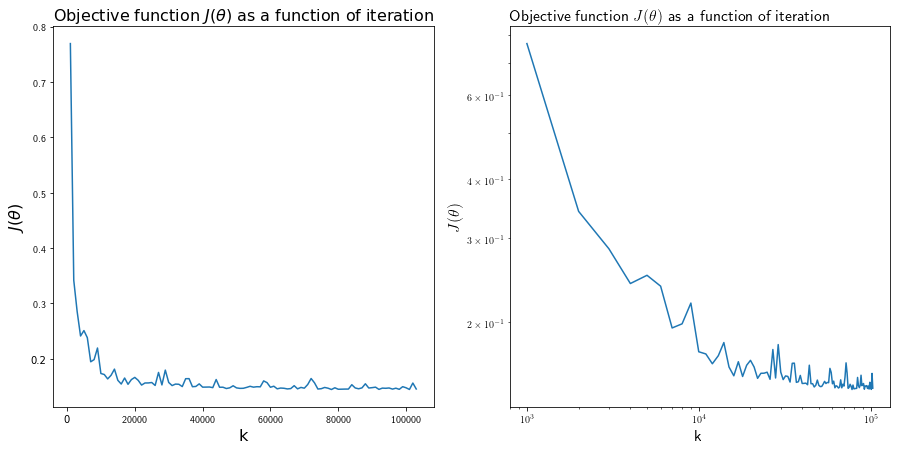

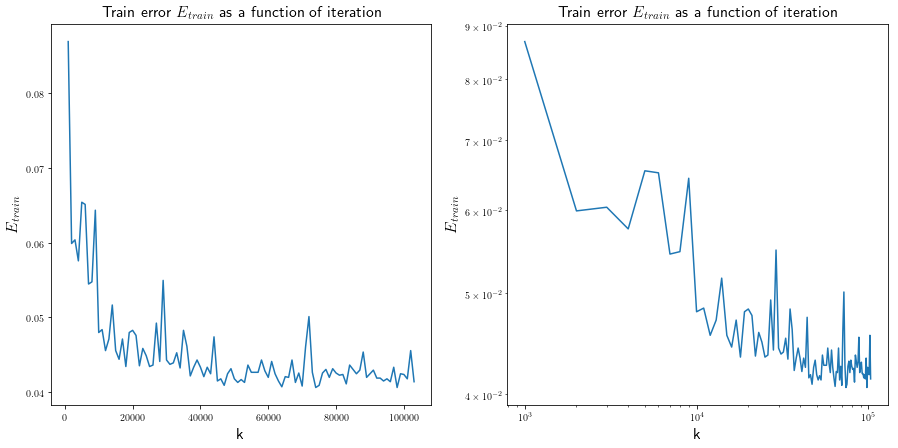

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
def obj_func(theta,X,y,lambda_par):
    J=0
    for i in range(len(X)):
        element = 0
        element = y[i]*theta.T@X[i,:]
        if 1-element>0:
            J = J + 1 - element
                
    J = lambda_par/2*theta.T@theta + 1/len(X)*J     
    return J

def svm_sgd2(X,y,lambda_par,T,max_epochs=10):
    # X ... Input variables (n x p matrix)
    # y ... Labels (n vector), -1 or 1
    # lambda_par ... Regularization constant (non-negative)
    # max_epochs ... Maximum number of "passes" through the data set

    assert(lambda_par > 0)
    n = X.shape[0]
    p = X.shape[1]
    max_iter = max_epochs*n
    theta = np.zeros(p)
    J = np.empty(0)
    no_k = np.empty(0) 
    errors = np.empty(0)
    for k in range(1,max_iter):
        i = np.random.randint(n)
        alpha = 1/(lambda_par*k)
        if k%T == 0:
            J = np.append(J,obj_func(theta,X,y,lambda_par))
            no_k = np.append(no_k,k)
            ypred_train = np.sign(theta@X_train.T)
            errors = np.append(errors,np.average(ypred_train != y_train))
        if y[i]*theta.T@X[i,:]<1:
            theta = theta - alpha*(lambda_par*theta-y[i]*X[i,:])
        else:
            theta = theta - alpha*lambda_par*theta
    return theta, J, no_k, errors

T = 1000
lambda_par = 1/100
max_epochs = 10
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
theta, J, no_k, errors = svm_sgd2(X_train,y_train,lambda_par, T,max_epochs)

sign = theta@X_train.T
X_train_neg = X_train[np.where(sign<0)] # skv. módelinu
X_train_pos = X_train[np.where(sign>=0)] # skv. módelinu
X_train_m = X_train[np.where(y_train == -1)]
X_train_p = X_train[np.where(y_train == 1)]
ypred_train = np.sign(sign)

print('Train Error:    {0:1.4f}'.format(np.average(ypred_train != y_train)))


plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.rc('text', usetex=True)
plt.plot(no_k,J)
plt.title(r'Objective function $J(\theta)$ as a function of iteration',fontsize=16)
plt.ylabel(r'$J(\theta)$',fontsize=16)
plt.xlabel(r'k',fontsize=16)

plt.subplot(1,2,2)
plt.loglog(no_k,J)
plt.title(r'Objective function $J(\theta)$ as a function of iteration',fontsize=16)
plt.ylabel(r'$J(\theta)$',fontsize=16)
plt.xlabel(r'k',fontsize=16)

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.rc('text', usetex=True)
plt.plot(no_k,errors)
plt.title(r'Train error $E_{train}$ as a function of iteration',fontsize=16)
plt.ylabel(r'$E_{train}$',fontsize=16)
plt.xlabel(r'k',fontsize=16)

plt.subplot(1,2,2)
plt.loglog(no_k,errors)
plt.title(r'Train error $E_{train}$ as a function of iteration',fontsize=16)
plt.ylabel(r'$E_{train}$',fontsize=16)
plt.xlabel(r'k',fontsize=16)


In [8]:
#ii) Evaluate classifier accuracy using the test set 
#(digits 5 and 8 only) using your classifier.

ypred_test = np.sign(theta@X_test.T)
print('Test Error:    {0:1.4f}'.format(np.average(ypred_test != y_test)))

Test Error:    0.0445


In [9]:
#iii) Compare the accuracy of your classifier 
#with the SVM implementation in sklearn.svm.LinearSVC.
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train,y_train)
print('Train accuracy:',round(clf.score(X_train,y_train),4))
print('Train error:',1-round(clf.score(X_train,y_train),4))
print('Test accuracy:',round(clf.score(X_test,y_test),4))
print('Test error:',1-round(clf.score(X_test,y_test),4))


Train accuracy: 0.9772
Train error: 0.022800000000000042
Test accuracy: 0.9582
Test error: 0.04179999999999995


2) [Spam filtering, 30 points - This is based on a problem from Andrew Ng's machine learning course at Stanford]
In recent years, spam on electronic newsgroups has been an increasing problem. Here, you will
build a classifier to distinguish between "real" newsgroup messages, and spam messages.
For this experiment, a set of spam emails and a set of genuine newsgroup messages have been obtained.
Using only the subject line and body of each message, we’ll learn to distinguish
between the spam and non-spam.
All the files for the problem are in the file `email_spam.zip`.
In order to get the text emails into a form usable by a off-the shelf classifier, some preprocessing on the
messages has already been performed. You can look at two sample spam emails in the files `spam_sample_original`,
and their preprocessed forms in the files `spam_sample_preprocessed*`. The first line in
the preprocessed format is just the label and is not part of the message. The preprocessing
ensures that only the message body and subject remain in the dataset; email addresses
(EMAILADDR), web addresses (HTTPADDR), currency (DOLLAR) and numbers (NUMBER)
were also replaced by the special tokens to allow them to be considered properly in the
classification process. (In this problem, we’ll going to call the features "tokens" rather than
"words," since some of the features will correspond to special values like EMAILADDR.
You don’t have to worry about the distinction.) The files `news_sample original` and
`news_sample_preprocessed` also give an example of a non-spam mail.

The work to extract feature vectors (i.e. classifier inputs) out of the documents has also been done for you, so you
can just load in the design matrices (called document-word matrices in text classification)
containing all the data. In a document-word matrix, the $i$-th row represents the $i$-th document/email,
and the $j$-th column represents the $j$-th distinct token. Thus, the $(i,j)$-entry of
this matrix represents the number of occurrences of the $j$-th token in the $i$-th document.

For this problem, we’ve chosen as our set of tokens considered (that is, as our vocabulary)
only the medium frequency tokens. The intuition is that tokens that occur too often or
too rarely do not have much classification value. (Examples tokens that occur very often
are words like "the", "and", and "of", which occur in so many emails and are sufficiently
content-free that they aren’t worth modeling.) Also, words were stemmed using a standard
stemming algorithm; basically, this means that “price,” “prices” and “priced” have all been
replaced with “price,” so that they can be treated as the same word. For a list of the tokens
used, see the variable file `tokenlist`.
Since the document-word matrix is extremely sparse (has lots of zero entries), we have
stored it in our own efficient format to save space. You don’t have to worry about this
format. The file `read_spam_data.py` provides the function `read_matrix` to read in the document-word
matrix and labels.

a) [15 points] Train a linear SVM on this dataset using the implementation in `sklearn.svm.LinearSVC`
and $C=0.1$. Evaluate the accuracy on the test set for training sets of size 50, 100,
200, 400, 800 and 1400 and for the full test set as well.

*Comment*: To read the training and test data and the list of tokens behind the features use
```python
    trainMatrix, tokenlist, trainCategory = readMatrix('MATRIX.TRAIN')
    testMatrix, tokenlist, testCategory = readMatrix('MATRIX.TEST')```

In [140]:
import read_spam_data as rsd
from sklearn.svm import LinearSVC
trainMatrix, tokenlist, trainCategory = rsd.read_matrix('MATRIX.TRAIN')
testMatrix, tokenlist, testCategory = rsd.read_matrix('MATRIX.TEST')

trainMatrix50, tokenlist50, trainCategory50 = rsd.read_matrix('MATRIX.TRAIN.50')
trainMatrix100, tokenlist100, trainCategory100 = rsd.read_matrix('MATRIX.TRAIN.100')
trainMatrix200, tokenlist200, trainCategory200 = rsd.read_matrix('MATRIX.TRAIN.200')
trainMatrix400, tokenlist400, trainCategory400 = rsd.read_matrix('MATRIX.TRAIN.400')
trainMatrix800, tokenlist800, trainCategory800 = rsd.read_matrix('MATRIX.TRAIN.800')
trainMatrix1400, tokenlist1400, trainCategory1400 = rsd.read_matrix('MATRIX.TRAIN.1400')


lsvm = LinearSVC(C=0.1) 
lsvm.fit(trainMatrix,trainCategory)
print(lsvm.score(testMatrix,testCategory))

lsvm50 = LinearSVC(C=0.1) 
lsvm50.fit(trainMatrix50,trainCategory50)
print('50:',lsvm50.score(testMatrix,testCategory))

lsvm100 = LinearSVC(C=0.1) 
lsvm100.fit(trainMatrix100,trainCategory100)
print('100:',lsvm100.score(testMatrix,testCategory))

lsvm200 = LinearSVC(C=0.1) 
lsvm200.fit(trainMatrix200,trainCategory200)
print('200:',lsvm200.score(testMatrix,testCategory))

lsvm400 = LinearSVC(C=0.1) 
lsvm400.fit(trainMatrix400,trainCategory400)
print('400:',lsvm400.score(testMatrix,testCategory))

lsvm800 = LinearSVC(C=0.1) 
lsvm800.fit(trainMatrix800,trainCategory800)
print('800:',lsvm800.score(testMatrix,testCategory))

lsvm1400 = LinearSVC(C=0.1) 
lsvm1400.fit(trainMatrix1400,trainCategory1400)
print('1400:',lsvm1400.score(testMatrix,testCategory))

0.9725
50: 0.92125
100: 0.94625
200: 0.95625
400: 0.95625
800: 0.97
1400: 0.965


b) [15 points] Classifier accuracy is in general strongly dependent on the selection of inputs to the classifier. The GIGO principle (garbage in, garbage out) usually applies. While some classifiers are quite tolerant towards noisy/irrelevant inputs (e.g. tree-based classifiers), the performance of other classifiers can degrade quickly (e.g. nonlinear SVMs). In the *feature selection* problem the task is to identify which features are most relevant for a given classification problem. By performing a careful selection of features, the performance of a classifier can often be improved significantly. Alternatively, it can be interesting to identify a minimal set of features for acceptable performance (e.g. due to high costs of collecting/measuring the full feature set).

A simple feature selection strategy considers the weights in a linear SVM after training has been performed. The larger $|\theta_k|$ is, the larger the role of the corresponding feature in the decision function. The strategy is therefore to rank the features according to $|\theta_k|$.

i) Train a linear SVM on the full spam data set and list the 10 tokens most important tokens in the above sense.

ii) Retrain a Linear SVM using only the most important 20 features/tokens. How does the accuracy compare with the full classifier?

*Comment*: The weights are stored in the `coef_` attribute in the LinearSVC class. The above feature selection method is discussed in http://proceedings.mlr.press/v3/chang08a/chang08a.pdf

In [148]:
#i)
import numpy as np
theta = lsvm.coef_
abstheta = abs(theta)
#10 stærstu theta:
index10 = np.argsort(abstheta)[0,-10:][::-1]
max10_theta = theta[0,index10]
print(max10_theta)


[ 0.41427361  0.41171377 -0.36579293  0.27131702 -0.25575369  0.24923277
  0.23578956  0.23437205  0.2304037   0.22636743]


In [149]:
#ii)
index20 = np.argsort(abstheta)[0,-20:][::-1]
max20_theta = theta[0,index20]
print(max20_theta)

[ 0.41427361  0.41171377 -0.36579293  0.27131702 -0.25575369  0.24923277
  0.23578956  0.23437205  0.2304037   0.22636743  0.22395683 -0.20556691
  0.20125095 -0.19291662 -0.18271114 -0.1823531   0.18159919  0.17945918
 -0.1778779  -0.17268974]


In [150]:
n = trainMatrix.shape[0]
p = trainMatrix.shape[1]
#Vil núlla alla dálka úr trainmatrix sem eru ekki einn af þessum 20

trainMatrix2 = np.zeros((n,p))
for i in range(n):
    for j in range(20):
        trainMatrix2[i,index20[j]] = trainMatrix[i,index20[j]]

lsvmDonk = LinearSVC(C=0.1)
lsvmDonk.fit(trainMatrix2,trainCategory)


print('Train accuracy:',round(lsvmDonk.score(trainMatrix,trainCategory),4))
print('Test accuracy:',lsvmDonk.score(testMatrix,testCategory))

Train accuracy: 0.9506
Test accuracy: 0.9525


Nákvæmnin(Test accuracy) sem fæst þegar allir Tokens eru notaðir er skv. (a) lið: $A^{P=all}_{test} = 0.9725$ en þegar einunigs 20 Tokens eru notaðir fæst $A^{P=20}_{test} = 0.9525$. Þannig að það fæst meiri nákvæmni ef allir Tokens eru notaðir en þó svo að einungis 20 séu notaðir fæst merkilega mikil nákvæmni.

3) [SVM classifier with RBF kernel, 30 points] Train an SVM with RBF kernel on the MNIST data set from last week. Use the validation set to select optimal values of $C$ and the RBF parameter $\gamma$ by performing a "grid search" on the validation set. This is simply a double for-loop where the outer loop iterates over one parameter and the inner loop over the other. For each $(C,\gamma)$ pair train an RBF SVM on a random subset of the training data (e.g. with 5000 samples, otherwise the training time may become prohibitively long) and evaluate accuracy on the validation set. Use the the following values for $C$, [1, 10, 100] and [1/10, 1/100, 1/1000] for $\gamma$. Use the best $(C,\gamma)$ pair to train a final classifier, using as much of the training data as you can and report the test set error. How does the performance compare to last week's $k$-NN and logistic regression classifiers?

*Comment*: Use the `sklearn.svm.SVC` implementation in scikit-learn. The training is time consuming since multiclass problems are handled in a one-against-one scheme which results in (10)(9)/2=45 binary classifiers that need to be trained. Since we have a separate validation set we avoid performing $k$-fold cross-validation on all 45 classifiers, with $k$ typically 5 or 10 this could increase the training time 10-fold.

In [9]:
# Insert code here
# ...